# **Introdução**

**Ideia Geral**

Utilizando os dados de câncer da FOSP, somente do tipo colorretal, serão utilizados quatro modelos de machine learning diferentes, com o intuito de testar diferentes tipos de algoritmo na classificação de sobrevida por um ano.

O label é 0 se o paciente não sobreviveu após um ano do diagnóstico e 1 se sobreviveu.

**Modelos de ML**

Foram escolhidos os modelos Naive Bayes, que utiliza o Teorema de Bayes para realizar as previsões, Random Forest, XGBoost e LightGBM, que utilizam os conceitos de árvores de decisão, além de bagging e boosting. Além disso, será testado um modelo de votação com os melhores classificadores obtidos, visando obter um algoritmo ainda mais acertivo.

**Validação dos modelos**

Para validar os modelos treinados foi utilizada primeiramente a matriz de confusão, sendo possível avaliar os acertos em ambas as classes. Para entender de houve overfitting nos modelos, foi utilizada a curva ROC para os conjuntos de treino e teste, comparando a métrica AUC entre ambos os conjuntos.

Por fim, os modelos Random Forest, XGBoost e LightGBM oferecem a possibilidade de saber quais foram as features mais importantes, ou seja, que mais influenciam na previsão das classes. Assim, foram mostradas duas maneiras diferentes de analisar a importância das variáveis de entrada, uma usando a própria função dos modelos e outra usando a biblioteca SHAP, que mostra a influência das features em ambas as classes.

In [ ]:
# Leitura dos dados
df = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_labels.csv')
df.head(3)

(31916, 37)


,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,...,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,...,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,...,3509502,2680,2744,2674,1,1,1,1,1,4.0
2,4,19,1,3516200,9,2,IIB,II,F,0,...,3516200,4725,4734,4719,0,0,1,1,1,4.0


In [ ]:
# Valores faltantes
df.isna().sum().sort_values(ascending=False).head(6)

ESCOLARI     0
CONSDIAG     0
DIAGTRAT     0
ANODIAG      0
FAIXAETAR    0
DRS          0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df.corr()
abs(corr_matrix['vivo_ano1']).sort_values(ascending = False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


vivo_ano1       1.000000
vivo_ano3       0.529451
ULTIDIAG        0.521620
ULTICONS        0.516761
ULTITRAT        0.513101
vivo_ano5       0.369942
obito_cancer    0.279604
obito_geral     0.261431
CIRURGIA        0.178875
RECNENHUM       0.164131
QUIMIO          0.150516
ANODIAG         0.106157
ULTINFO         0.103939
DIAGTRAT        0.088385
RADIO           0.085948
IDADE           0.084717
TRATCONS        0.063135
ESCOLARI_2      0.045089
HORMONIO        0.034786
DIAGPREV        0.032389
Name: vivo_ano1, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df.vivo_ano1.value_counts()

1    23200
0     8716
Name: vivo_ano1, dtype: int64

In [ ]:
df[['obito_geral', 'ULTIDIAG', 'vivo_ano1', 'vivo_ano3', 'vivo_ano5']].sample(5)

,obito_geral,ULTIDIAG,vivo_ano1,vivo_ano3,vivo_ano5
19425,0,1554,1,1,0
23922,0,3676,1,1,1
4295,1,3,0,0,0
17873,0,6359,1,1,1
4395,1,14,0,0,0


## **DataFrame vivo_ano1**

Antes de realizar o pré-processamento dos dados é necessário filtrar os dados, de modo a retirar pacientes que não foram acompanhados por pelo menos **um ano** e que a última informação consta como vivos.

In [ ]:
# Dataset da sobrevida de um ano
df_ano1 = df[~((df.obito_geral == 0) & (df.vivo_ano1 == 0))].reset_index(drop=True)
df_ano1.shape

(29670, 37)

In [ ]:
df_ano1.head(3)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,...,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,...,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,...,3509502,2680,2744,2674,1,1,1,1,1,4.0
2,4,19,1,3516200,9,2,IIB,II,F,0,...,3516200,4725,4734,4719,0,0,1,1,1,4.0


# **Análise - Sobrevida um ano**

## **Pré-processamento**

Como o dataset já foi limpo anteriormente, aqui na etapa de pré-processamento serão realizadas a divisão dos dados em treino e teste, a codificação das colunas textuais para colunas numéricas e a normalização dos dados. Com isso, temos os dados prontos para o treinamento dos modelos de machine learning e consequentemente sua validação.

Neste primeiro momento, serão definidas as colunas que não serão utilizadas como features, assim, foi escolhido manter a coluna `IDADE`, então a coluna `FAIXAETAR` será retirada. O mesmo ocorre com a coluna `EC`, retirando a coluna `ECGRUP`. Por fim, as outras colunas contidas na `list_drop` são possíveis saídas para os modelos, mas estamos interessados somente na sobrevida de um ano, por isso só ela será mantida como label e as outras serão retiradas.

In [ ]:
list_drop = ['FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 'obito_geral', 
             'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'obito_cancer', 'ECGRUP', 'ESCOLARI']

lb = 'vivo_ano1'

Uma função foi criada para realizar o pré-processamento inteiro, chamada `preprocessing`, internamente ela utiliza outras funções criadas que são: `get_train_test` (divide os dados em treino e teste), `train_preprocessing` (prepara os dados de treino) e `test_preprocessing` (prepara os dados de teste). 

> Mais detalhes em [funções](https://colorectal-site.readthedocs.io/en/latest/Fun%C3%A7%C3%B5es.html#Fun%C3%A7%C3%B5es).

In [ ]:
X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_ano1, list_drop, lb, 
                                                                       random_state=seed,
                                                                       balance_data=False,
                                                                       encoder_type='LabelEncoder', 
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True)

X_train = (22252, 25), X_test = (7418, 25)
y_train = (22252,), y_test = (7418,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.781952
0    0.218048
Name: vivo_ano1, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.781882
0    0.218118
Name: vivo_ano1, dtype: float64

## **Treinamento e validação dos modelos de machine learning**

Depois das etapas de preparação, os dados estão prontos para serem utilizados nos modelos escolhidos.

### **Naive Bayes**

In [ ]:
# Criação e treinamento do modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

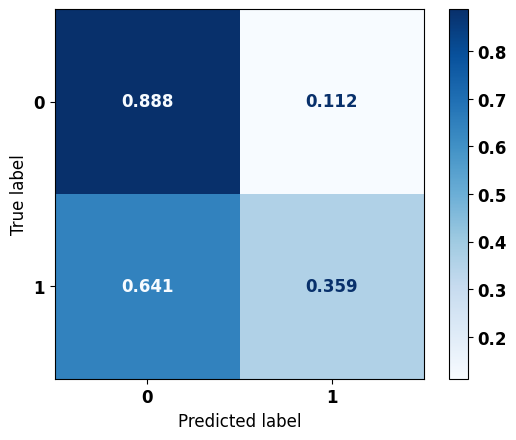


              precision    recall  f1-score   support

           0      0.279     0.888     0.424      1618
           1      0.920     0.359     0.516      5800

    accuracy                          0.474      7418
   macro avg      0.599     0.623     0.470      7418
weighted avg      0.780     0.474     0.496      7418



In [ ]:
# Matriz de confusão
plot_confusion_matrix(nb, X_test, y_test)

> Claramente percebe-se que o modelo previu boa parte dos dados como sendo da classe 0, portanto não teve um aprendizado satisfatório. 

> Na matriz de confusão, buscamos uma diagonal principal equilibrada e com a maior acertividade possível.

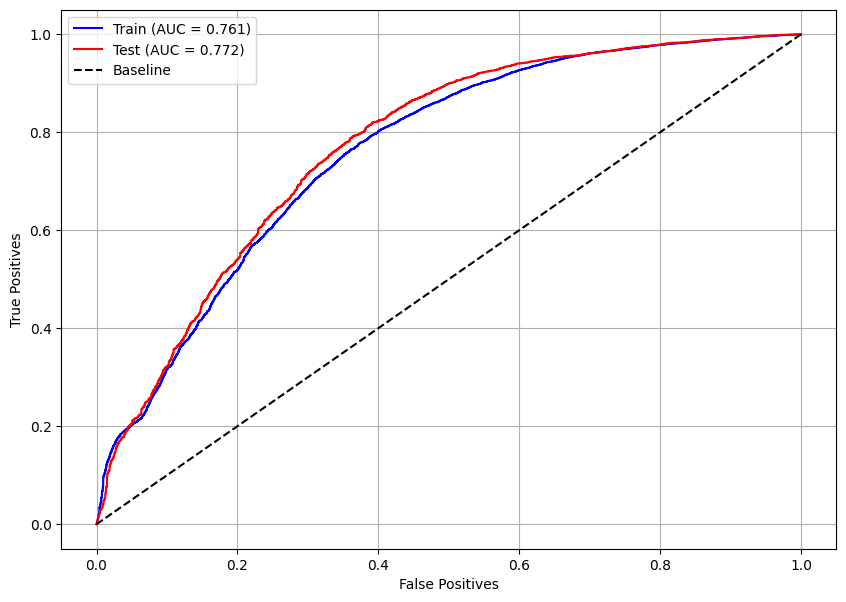

In [ ]:
# Curva ROC
plot_roc_curve(nb, X_train, X_test, y_train, y_test)

> Pelas curvas ROC, pode-se dizer que não há overfitting, mas o modelo é ruim para a previsão da classe 1, portanto qualquer análise além dessa não possui tanta relevância.

### **Random Forest**


O modelo Random Forest é mais complexo em relação ao Naive Bayes, assim alguns hiperparâmetros serão definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será definido como 8, pois o padrão do modelo é não ter profundidade máxima para as árvores, o que dificulta e faz o treinamento ser muito longo, além da maior chance de overfitting.

* `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo, muito útil quando temos classes desbalanceadas no conjunto de dados, como neste caso.

In [ ]:
# Criação e treinamento do modelo Random Forest 
rf = RandomForestClassifier(random_state=seed, 
                            class_weight={0:3.75, 1:1},
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 3.75, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

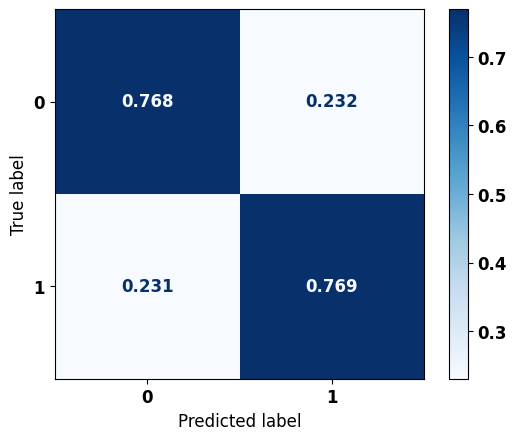


              precision    recall  f1-score   support

           0      0.481     0.768     0.592      1618
           1      0.922     0.769     0.839      5800

    accuracy                          0.769      7418
   macro avg      0.702     0.768     0.715      7418
weighted avg      0.826     0.769     0.785      7418



In [ ]:
# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

> A matriz obtida para o modelo Random Forest apresentou diagonal equilibrada em ambas as classes, com 77% de acurácia.


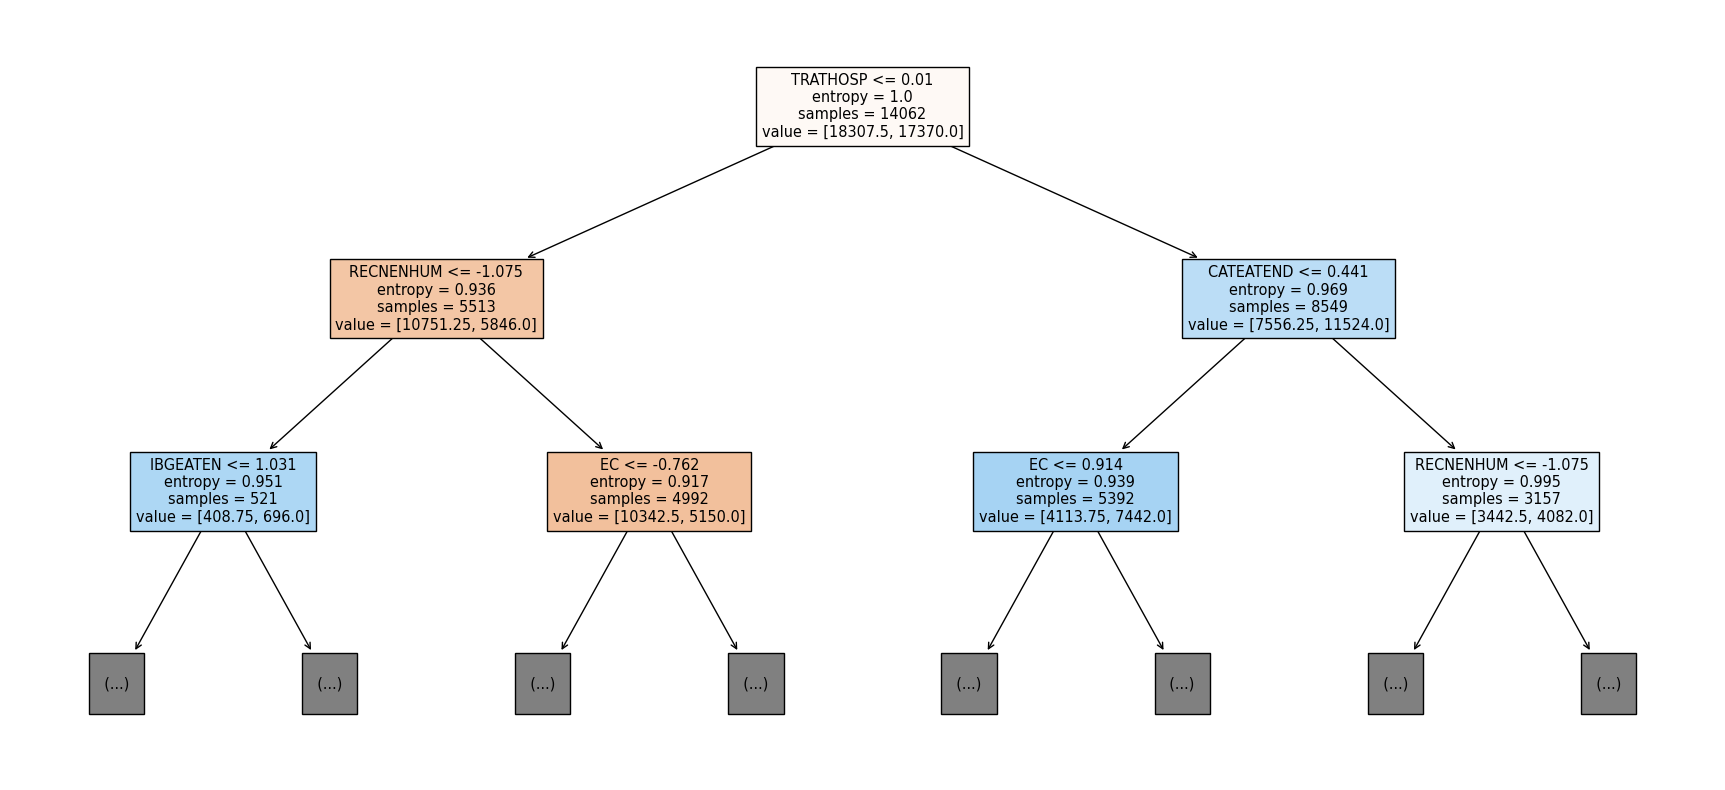

In [ ]:
# Pedaço de uma das árvores do modelo Random Forest
show_tree(rf, feat_cols, 2)

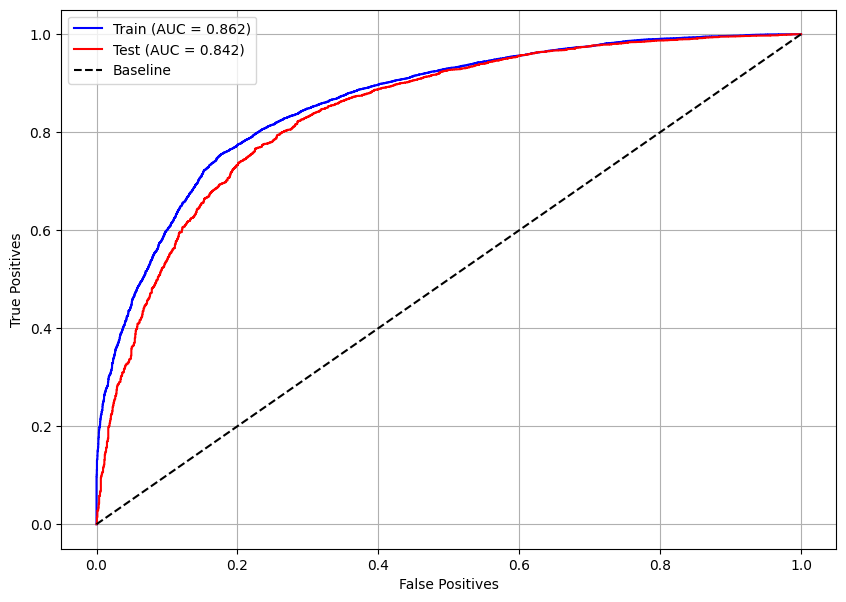

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,862 e 0,842 respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

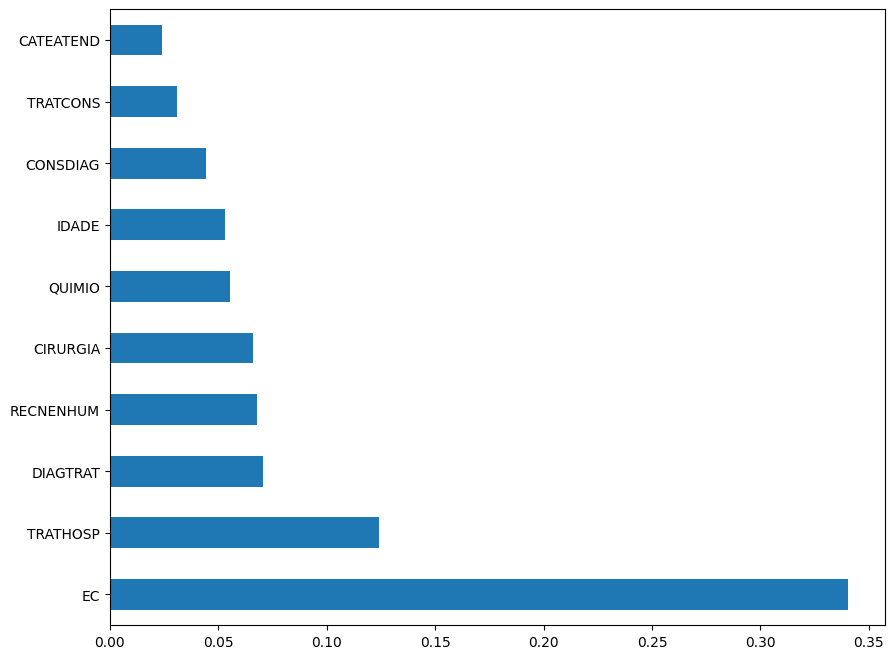

In [ ]:
# Importância das features
plot_feat_importances(rf, feat_cols)

> As features mais importantes nesta visualização são `EC`, com uma grande vantagem, `TRATHOSP`, `DIAGTRAT` e `RECNENHUM`. 

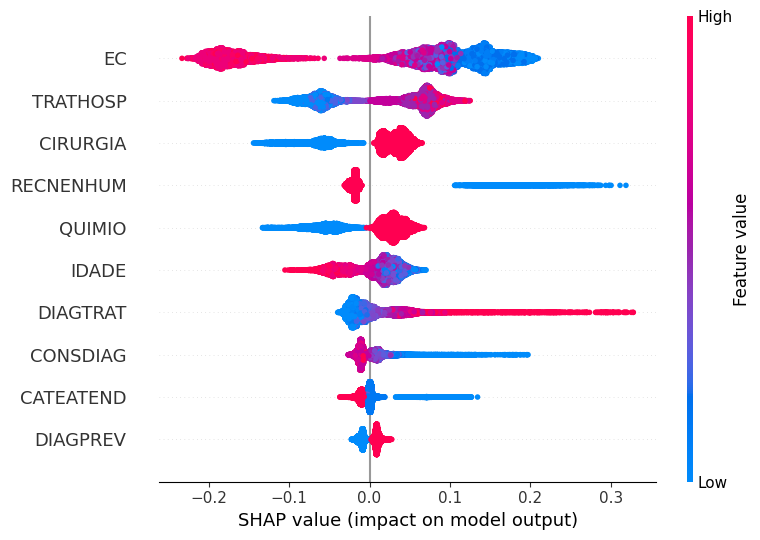

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

A coluna `EC` foi a mais importante aqui também, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao primeiro ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples, 
                                 criterion=optimizer,
                                 random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=62, state=TrialState.COMPLETE, values=[0.6665759868570232], datetime_start=datetime.datetime(2023, 4, 11, 22, 14, 45, 562373), datetime_complete=datetime.datetime(2023, 4, 11, 22, 15, 33, 873202), params={'n_estimators': 173, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_samples': 0.7999999999999999, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=62, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 173,
 'max_depth': 18,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_samples': 0.7999999999999999,
 'criterion': 'gini'}

In [ ]:
plot_optimization_history(studyRF).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0: 24.5, 1: 1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 24.5, 1: 1}, max_depth=18,
                       max_samples=0.7999999999999999, min_samples_split=8,
                       n_estimators=173, random_state=10)

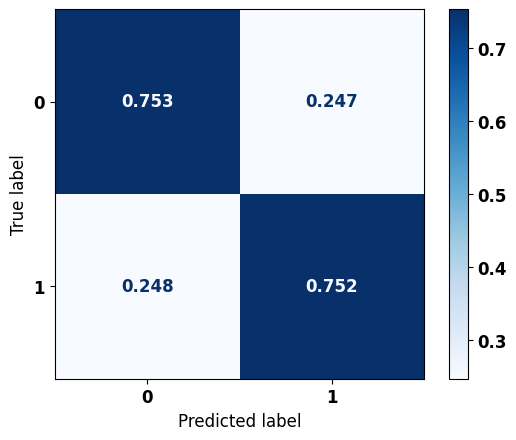


              precision    recall  f1-score   support

           0      0.458     0.753     0.570      1618
           1      0.916     0.752     0.826      5800

    accuracy                          0.752      7418
   macro avg      0.687     0.752     0.698      7418
weighted avg      0.816     0.752     0.770      7418



In [ ]:
# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

> Há uma queda de acurácia em relação ao primeiro modelo testado, de 77% para 75%. Os motivos podem ser variados, mas um deles talvez seja a escolha dos parâmetros e/ou overfitting, como mostrado na curva ROC a seguir.

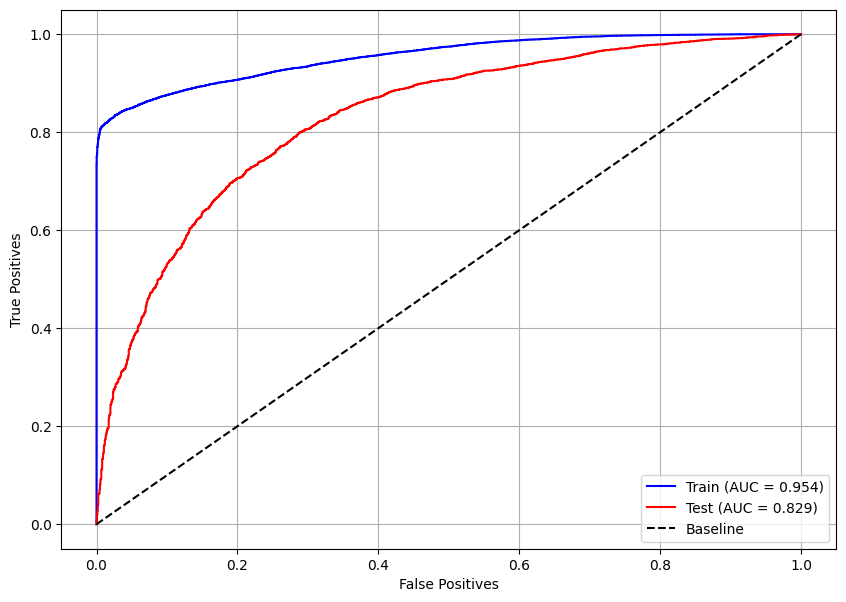

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui overfitting, pois para o conjunto de treino temos AUC = 0,954 e para o teste AUC = 0,829, essa diferença caracteriza o problema.

### **XGBoost**


O modelo XGBoost também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será utilizado o padrão do modelo, valor 3.

* `scale_pos_weight`: usado para definir o peso da classe 1 no treinamento do modelo, pois temos classes desbalanceadas.

In [ ]:
# Criação e treinamento do modelo XGBoost 
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=0.274,
                    random_state=seed)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

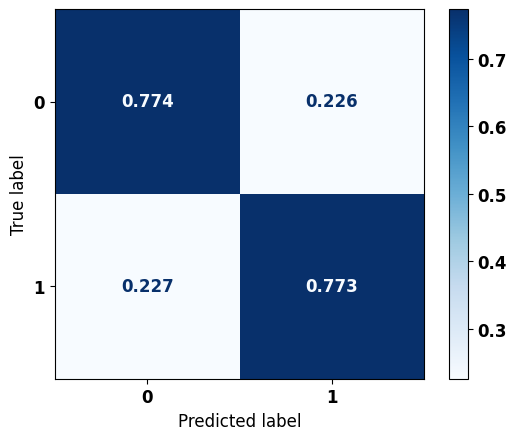


              precision    recall  f1-score   support

           0      0.488     0.774     0.598      1618
           1      0.925     0.773     0.842      5800

    accuracy                          0.773      7418
   macro avg      0.706     0.774     0.720      7418
weighted avg      0.829     0.773     0.789      7418



In [ ]:
# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

> A matriz obtida para o modelo XGBoost apresentou diagonal equilibrada em ambas as classes, com 77% de acurácia.


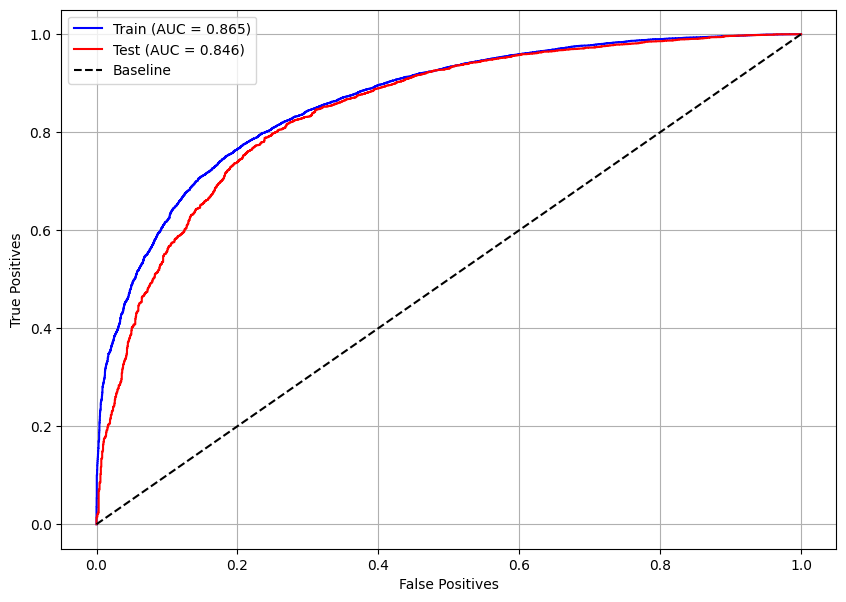

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,865 e 0,846 respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

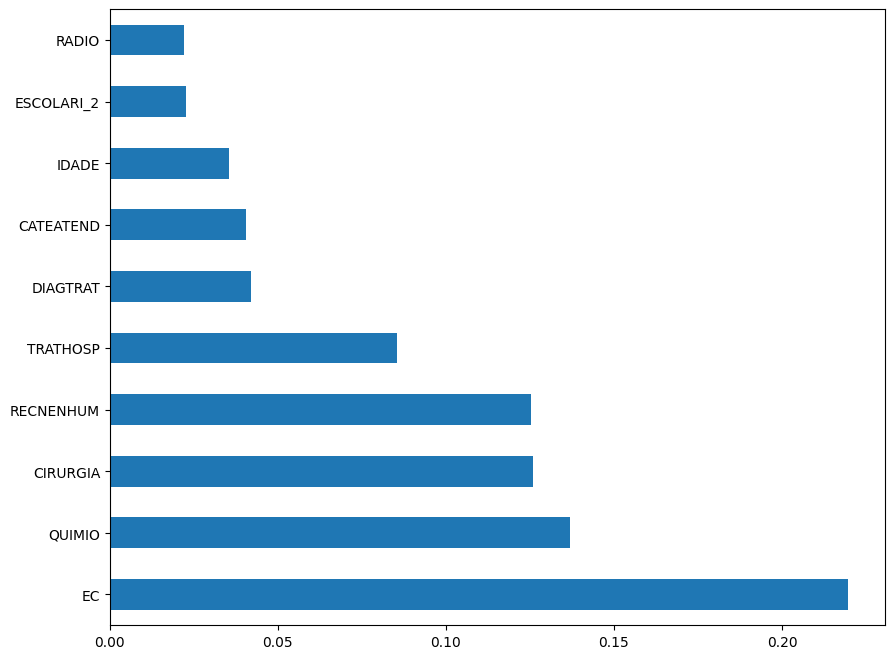

In [ ]:
# Importância das features
plot_feat_importances(xgb, feat_cols)

> As features mais importantes nesta visualização são `EC`, `QUIMIO`, `CIRURGIA` e `RECNENHUM`. 

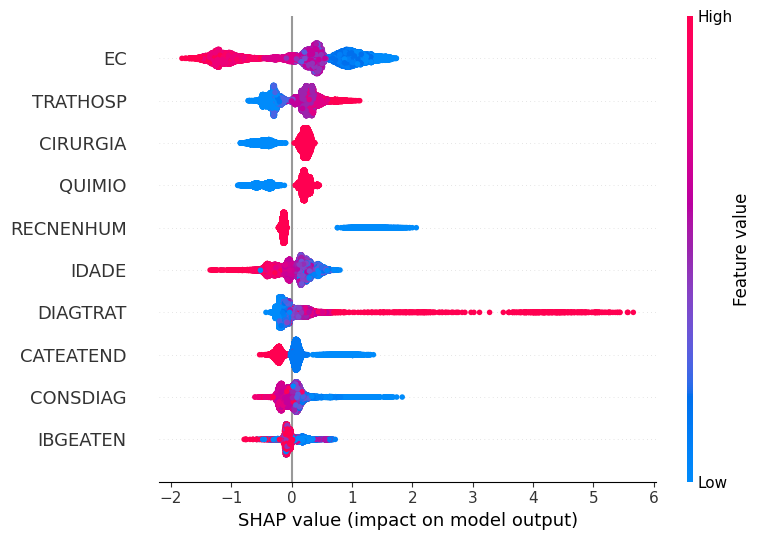

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

A coluna `EC` foi a mais importante aqui também, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao primeiro ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators, 
                        max_depth=max_depth, 
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight, 
                        colsample_bytree=colsample_bytree,
                        random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=34, state=TrialState.COMPLETE, values=[0.690408417561615], datetime_start=datetime.datetime(2023, 4, 11, 23, 4, 35, 672447), datetime_complete=datetime.datetime(2023, 4, 11, 23, 5, 11, 49526), params={'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'min_child_weight': 4, 'colsample_bytree': 0.6000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=34, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 127,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 4,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
plot_optimization_history(studyXGB).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.22

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=127, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

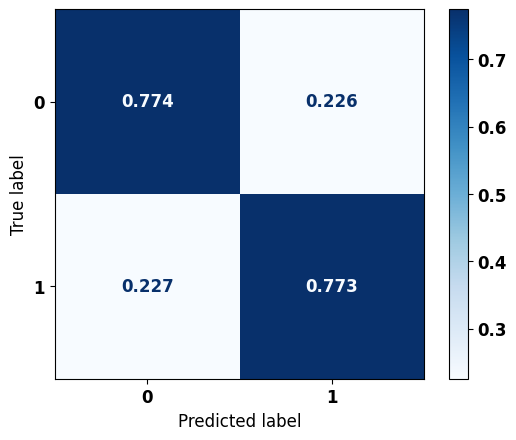


              precision    recall  f1-score   support

           0      0.488     0.774     0.599      1618
           1      0.925     0.773     0.842      5800

    accuracy                          0.774      7418
   macro avg      0.706     0.774     0.720      7418
weighted avg      0.829     0.774     0.789      7418



In [ ]:
# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

> Após a escolha dos hiperparâmetros, a acurácia de ambos os modelos ficou em torno de 77%.

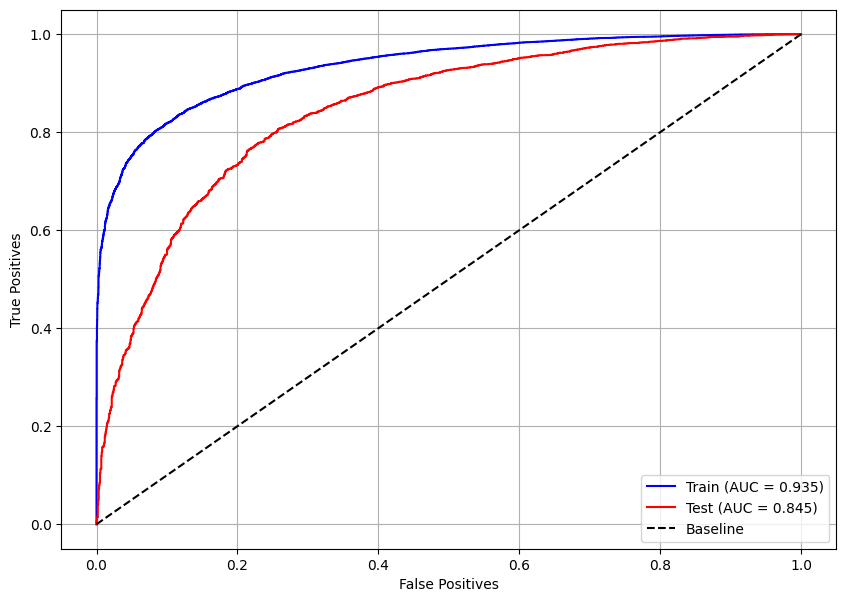

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui um pouco de overfitting, pois para o conjunto de treino temos AUC = 0,935 e para o teste AUC = 0,845, essa diferença caracteriza o problema.

### **ROCs**

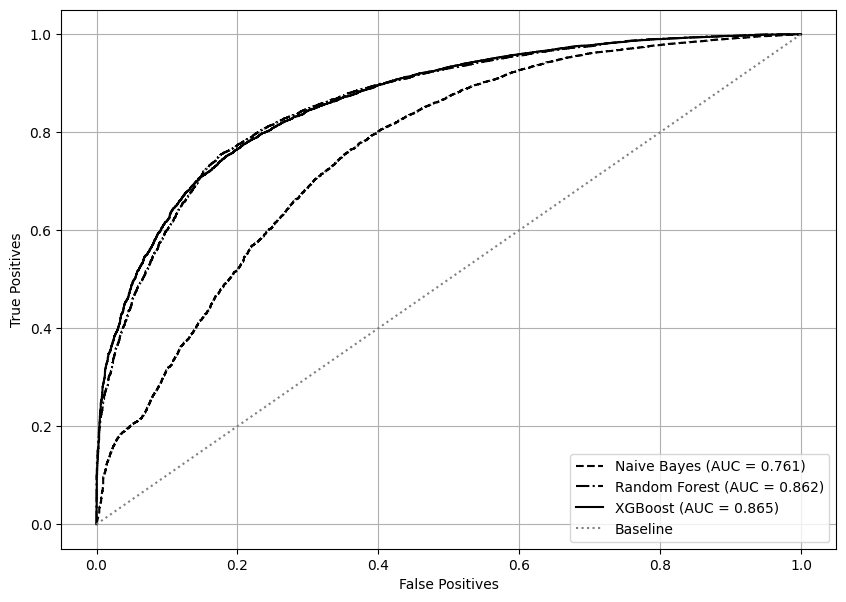

In [ ]:
# Treino
roc_together(X_train, y_train, nb, rf, xgb)

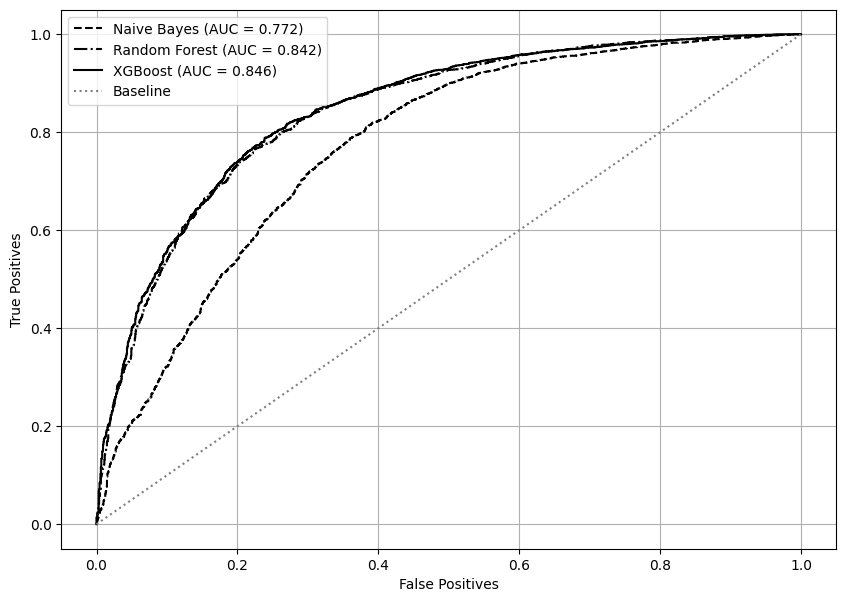

In [ ]:
# Teste
roc_together(X_test, y_test, nb, rf, xgb)

## **RN**

### **Importação das bibliotecas e funções**

In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Add, Input, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Definição de cores para gráficos
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_metrics(history):
    """Plot metrics after training the RNA.

    :param history: RNA training history.

    :return: no value
    :rtype: none
    """
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12,8))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+ metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        if metric == 'accuracy':
            plt.ylim([0.7, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

### **Criação e treinamento da RNA Complexa**

In [ ]:
neg, pos = np.bincount(y_train)
total = neg + pos
print(f'Exemplos:\n Total: {total}\n Positivos: {pos} ({100*pos/total:.2f}% do total)')

# Cálculo dos pesos das duas classe
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

# Dicionário de pesos das classes para treinamento
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Peso da classe 0: {:.2f}'.format(weight_for_0))
print('Peso da classe 1: {:.2f}'.format(weight_for_1))

Exemplos:
 Total: 22252
 Positivos: 17400 (78.20% do total)
Peso da classe 0: 2.29
Peso da classe 1: 0.64


In [ ]:
input_shape = X_train.shape[1:]
input_features = Input(shape=input_shape, name='input_features')

x1 = Dense(128, activation='tanh', kernel_regularizer=l2())(input_features)
x2 = Dense(128, activation='selu', kernel_regularizer=l2())(input_features)
x3 = Dense(128, activation='sigmoid', kernel_regularizer=l2())(input_features)

from tensorflow.keras.layers import Concatenate
x_concat = Concatenate()([x1, x2, x3, input_features])

x4 = Dense(32, activation='relu', kernel_regularizer=l2())(x_concat)
out = Dense(1, activation='sigmoid', name='out_dense')(x4)

model = keras.Model(inputs=[input_features],
                    outputs=[out])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 25)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          3328        ['input_features[0][0]']         
                                                                                                  
 dense_1 (Dense)                (None, 128)          3328        ['input_features[0][0]']         
                                                                                                  
 dense_2 (Dense)                (None, 128)          3328        ['input_features[0][0]']         
                                                                                              

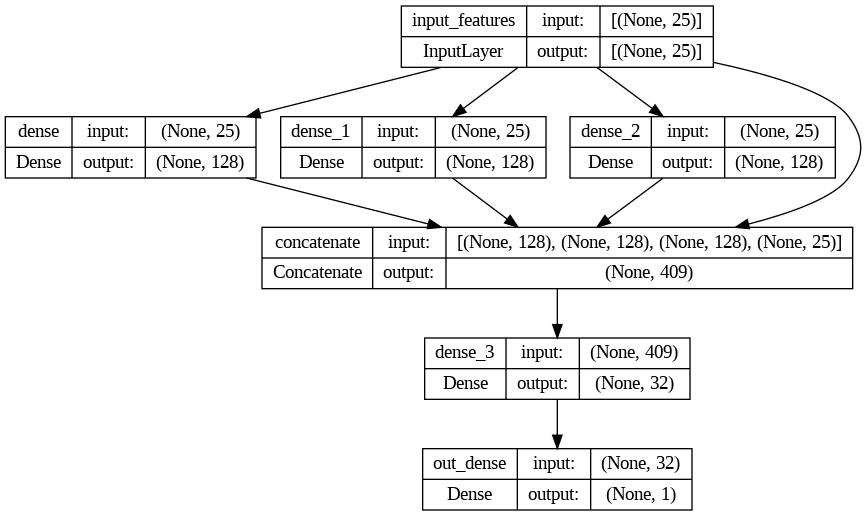

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define métricas
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

call_es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train, y_train, epochs=50, 
                    class_weight=class_weight, 
                    verbose=2, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[call_es])

Epoch 1/50
696/696 - 6s - loss: 0.9041 - accuracy: 0.7318 - precision: 0.9048 - recall: 0.7343 - auc: 0.7983 - val_loss: 0.4938 - val_accuracy: 0.8052 - val_precision: 0.8888 - val_recall: 0.8583 - val_auc: 0.8226 - 6s/epoch - 9ms/step
Epoch 2/50
696/696 - 2s - loss: 0.5664 - accuracy: 0.7316 - precision: 0.9031 - recall: 0.7357 - auc: 0.8048 - val_loss: 0.5486 - val_accuracy: 0.7478 - val_precision: 0.9135 - val_recall: 0.7483 - val_auc: 0.8260 - 2s/epoch - 3ms/step
Epoch 3/50
696/696 - 2s - loss: 0.5515 - accuracy: 0.7391 - precision: 0.9059 - recall: 0.7436 - auc: 0.8086 - val_loss: 0.5383 - val_accuracy: 0.7528 - val_precision: 0.9133 - val_recall: 0.7555 - val_auc: 0.8249 - 2s/epoch - 3ms/step
Epoch 4/50
696/696 - 4s - loss: 0.5464 - accuracy: 0.7447 - precision: 0.9079 - recall: 0.7497 - auc: 0.8106 - val_loss: 0.5182 - val_accuracy: 0.7672 - val_precision: 0.9048 - val_recall: 0.7848 - val_auc: 0.8246 - 4s/epoch - 5ms/step
Epoch 5/50
696/696 - 5s - loss: 0.5462 - accuracy: 0.741

**Resultados**

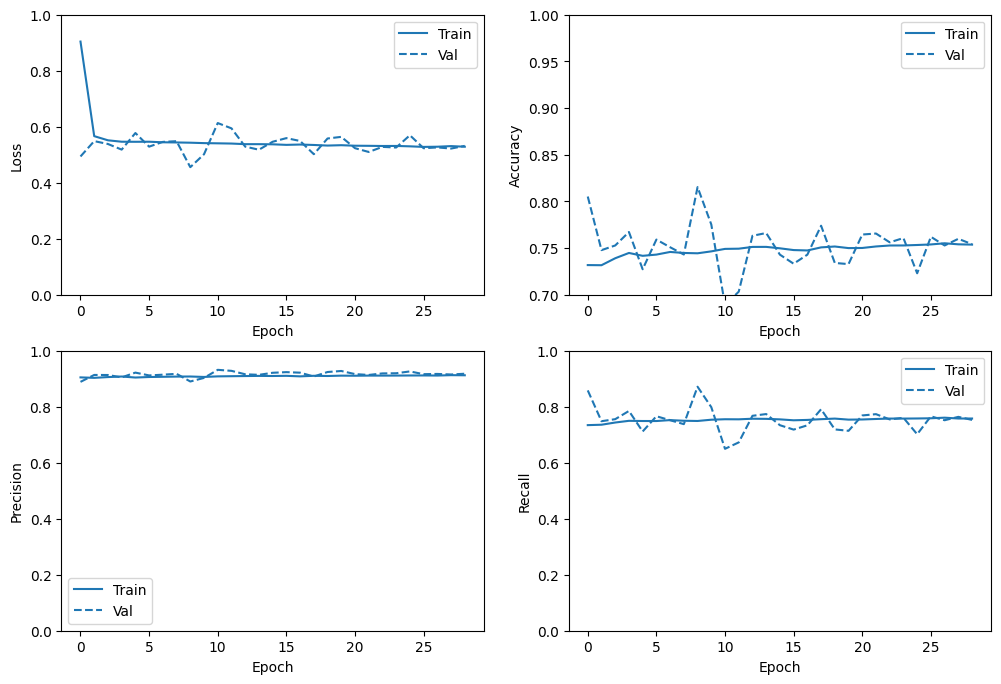

In [ ]:
plot_metrics(history)

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Número de exemplos positivos do conjunto de teste =', len(y_test[y_test > 0.9]))
results = model.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value:.4f}')

232/232 [==============================] - 0s 1ms/step
Número de exemplos positivos do conjunto de teste = 5800
loss: 0.4555
accuracy: 0.8153
precision: 0.8901
recall: 0.8714
auc: 0.8282


In [ ]:
precision = results[2]
recall = results[3]
F1 = 2*precision*recall/(precision + recall)
print(f'Pontuação F1 = {F1:.4f}')

Pontuação F1 = 0.8806


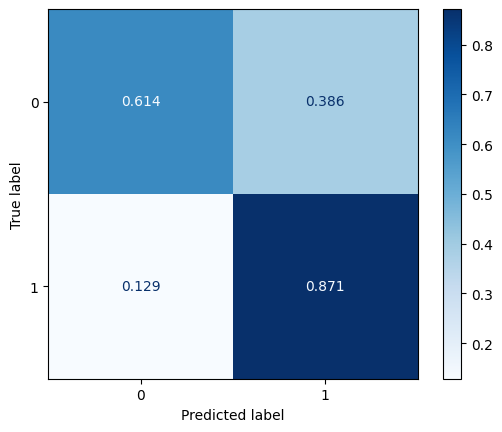

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred), 
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, np.round(test_pred))

0.742859000042624

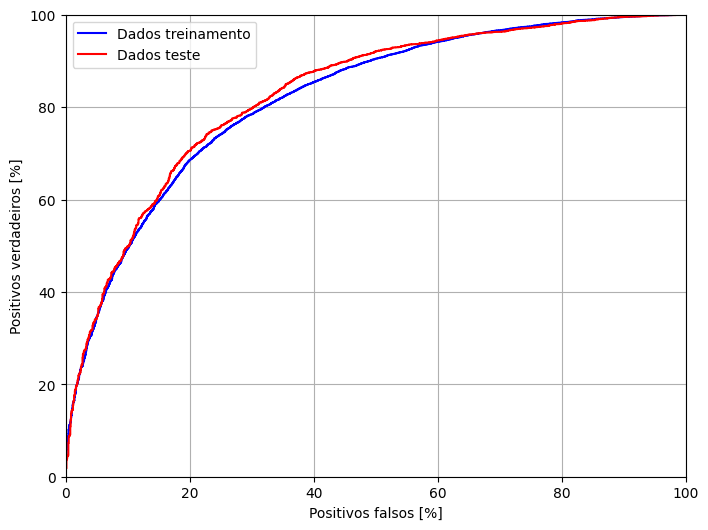

In [ ]:
fp_train, tp_train, _ = roc_curve(y_train, train_pred)
fp_test, tp_test, _ = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label='Dados treinamento')
plt.plot(100*fp_test, 100*tp_test, 'r', label='Dados teste')
plt.xlabel('Positivos falsos [%]')
plt.ylabel('Positivos verdadeiros [%]')
plt.xlim([0,100])
plt.ylim([0,100])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
custo_e_metricas_train = model.evaluate(X_train, y_train)
# custo_e_metricas_val = rna_reg.evaluate(X_val_norm, y_val)
custo_e_metricas_test = model.evaluate(X_test, y_test)

232/232 [==============================] - 1s 3ms/step - loss: 0.4555 - accuracy: 0.8153 - precision: 0.8901 - recall: 0.8714 - auc: 0.8282


### **Criação e treinamento da RNA Residual**

In [ ]:
# Função que cria o bloco para a RN residual
def bloco_residual(x, n):
    
    z1 = Dense(n, activation='relu')(x)
    z2 = Dense(n)(z1)
    sum = Add()([x, z2])
    a2 = Activation('relu')(sum)

    return a2

In [ ]:
# Definição da entrada
input_shape = X_train.shape[1:]
input_features = Input(shape=input_shape)

X1 = Dense(64, activation='relu')(input_features)

X2 = bloco_residual(X1, 64)

X3 = Dense(64, activation='relu')(X2)

X4 = bloco_residual(X3, 64)

X5 = Dense(16, activation='relu')(X4)

Y = Dense(units=1, activation='sigmoid')(X5)

# Criação da RNA
rna = Model(input_features, Y)

# Mostra resumo da RNA
rna.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 dense_99 (Dense)               (None, 64)           1664        ['input_13[0][0]']               
                                                                                                  
 dense_100 (Dense)              (None, 64)           4160        ['dense_99[0][0]']               
                                                                                                  
 dense_101 (Dense)              (None, 64)           4160        ['dense_100[0][0]']              
                                                                                           

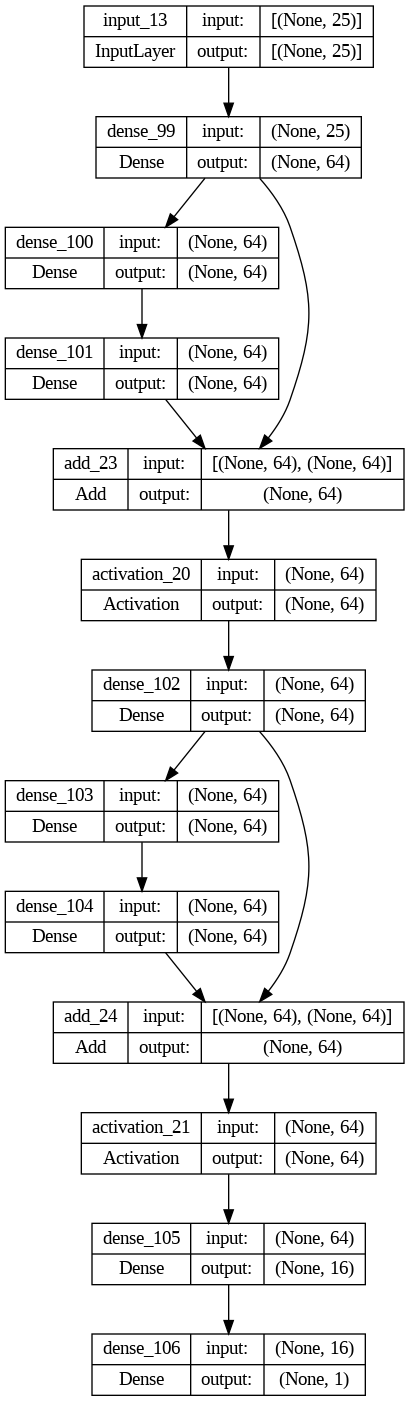

In [ ]:
keras.utils.plot_model(rna, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define métricas
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

call_es = EarlyStopping(monitor='val_loss', patience=20, 
                        restore_best_weights=True)

adam = Adam(learning_rate=0.001)
rna.compile(optimizer=adam, loss='binary_crossentropy',
              metrics=METRICS)

history = rna.fit(X_train, y_train, epochs=50, 
                    class_weight=class_weight, 
                    verbose=2, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[call_es])

Epoch 1/50
696/696 - 6s - loss: 0.9472 - accuracy: 0.7342 - precision: 0.9045 - recall: 0.7380 - auc: 0.8004 - val_loss: 0.5788 - val_accuracy: 0.7208 - val_precision: 0.9293 - val_recall: 0.6959 - val_auc: 0.8316 - 6s/epoch - 9ms/step
Epoch 2/50
696/696 - 4s - loss: 0.5237 - accuracy: 0.7491 - precision: 0.9116 - recall: 0.7521 - auc: 0.8207 - val_loss: 0.5463 - val_accuracy: 0.7340 - val_precision: 0.9257 - val_recall: 0.7174 - val_auc: 0.8337 - 4s/epoch - 6ms/step
Epoch 3/50
696/696 - 6s - loss: 0.5107 - accuracy: 0.7516 - precision: 0.9135 - recall: 0.7537 - auc: 0.8277 - val_loss: 0.5075 - val_accuracy: 0.7591 - val_precision: 0.9181 - val_recall: 0.7597 - val_auc: 0.8337 - 6s/epoch - 9ms/step
Epoch 4/50
696/696 - 5s - loss: 0.5063 - accuracy: 0.7559 - precision: 0.9166 - recall: 0.7567 - auc: 0.8309 - val_loss: 0.4829 - val_accuracy: 0.7749 - val_precision: 0.9096 - val_recall: 0.7907 - val_auc: 0.8333 - 5s/epoch - 7ms/step
Epoch 5/50
696/696 - 7s - loss: 0.5028 - accuracy: 0.760

**Resultados**

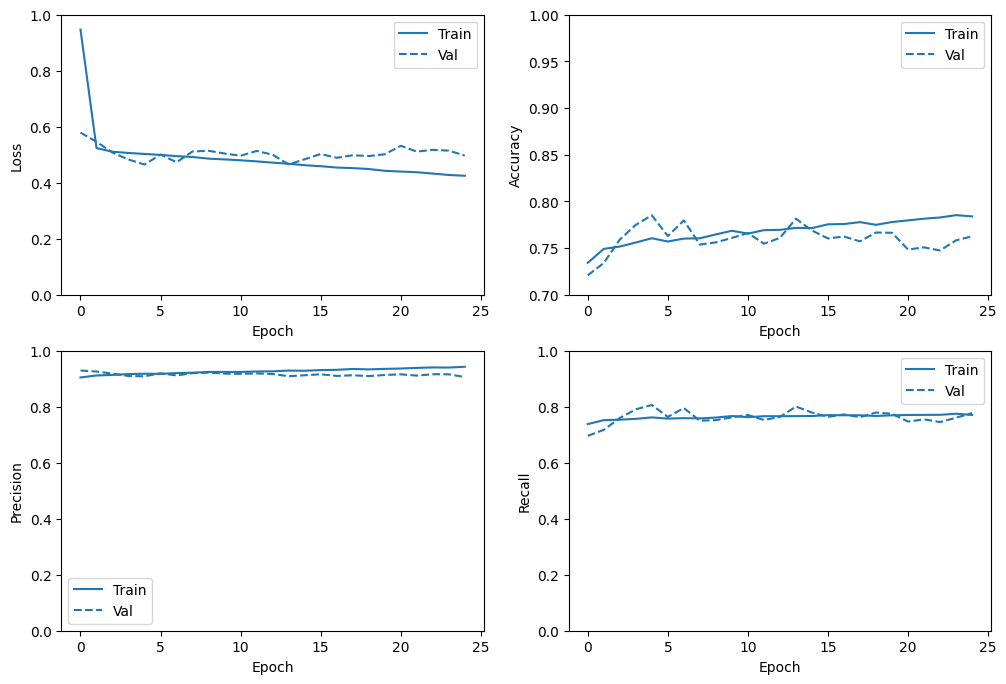

In [ ]:
plot_metrics(history)

In [ ]:
train_pred = rna.predict(X_train)
test_pred = rna.predict(X_test)

print('Número de exemplos positivos do conjunto de teste =', len(y_test[y_test > 0.9]))
results = rna.evaluate(X_test, y_test, verbose=0)

for name, value in zip(rna.metrics_names, results):
    print(f'{name}: {value:.4f}')

232/232 [==============================] - 1s 2ms/step
Número de exemplos positivos do conjunto de teste = 5800
loss: 0.4650
accuracy: 0.7851
precision: 0.9087
recall: 0.8062
auc: 0.8335


In [ ]:
precision = results[2]
recall = results[3]
F1 = 2*precision*recall/(precision + recall)
print(f'Pontuação F1 = {F1:.4f}')

Pontuação F1 = 0.8544


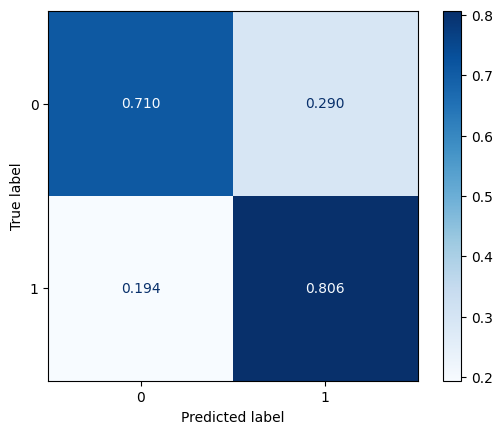

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred), 
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, np.round(test_pred))

0.7578624099569499

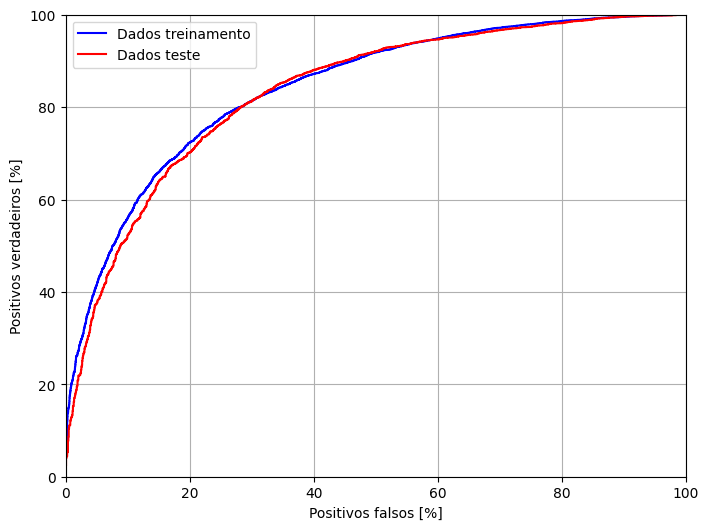

In [ ]:
fp_train, tp_train, _ = roc_curve(y_train, train_pred)
fp_test, tp_test, _ = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label='Dados treinamento')
plt.plot(100*fp_test, 100*tp_test, 'r', label='Dados teste')
plt.xlabel('Positivos falsos [%]')
plt.ylabel('Positivos verdadeiros [%]')
plt.xlim([0,100])
plt.ylim([0,100])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
custo_e_metricas_train = rna.evaluate(X_train, y_train)
custo_e_metricas_test = rna.evaluate(X_test, y_test)

232/232 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.7851 - precision: 0.9087 - recall: 0.8062 - auc: 0.8335


### **Criação e treinamento da RNA Sequencial**

In [ ]:
neg, pos = np.bincount(y_train)
total = neg + pos
print(f'Exemplos:\n Total: {total}\n Positivos: {pos} ({100*pos/total:.2f}% do total)')

# Cálculo dos pesos das duas classe
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

# Dicionário de pesos das classes para treinamento
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Peso da classe 0: {:.2f}'.format(weight_for_0))
print('Peso da classe 1: {:.2f}'.format(weight_for_1))

Exemplos:
 Total: 22252
 Positivos: 17400 (78.20% do total)
Peso da classe 0: 2.29
Peso da classe 1: 0.64


In [ ]:
rna = Sequential()
rna.add(Dense(units=128, activation='relu', input_shape=X_train.shape[1:]))
rna.add(Dense(units=128, activation='relu'))
rna.add(Dense(units=32, activation='relu'))
rna.add(Dense(units=1, activation='sigmoid'))
rna.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               3328      
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 24,001
Trainable params: 24,001
Non-trainable params: 0
_________________________________________________________________


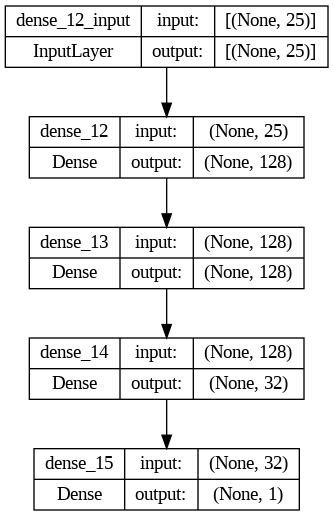

In [ ]:
keras.utils.plot_model(rna, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define métricas
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

call_es = EarlyStopping(monitor='val_loss', patience=20, 
                        restore_best_weights=True)

adam = Adam(learning_rate=0.001)
rna.compile(optimizer=adam, loss='binary_crossentropy',
            metrics=METRICS)

history = rna.fit(X_train, y_train, epochs=50, 
                  class_weight=class_weight, 
                  verbose=2, batch_size=32,
                  validation_data=(X_test, y_test),
                  callbacks=[call_es])

Epoch 1/50
696/696 - 4s - loss: 0.5404 - accuracy: 0.7324 - precision: 0.9068 - recall: 0.7332 - auc: 0.8038 - val_loss: 0.5814 - val_accuracy: 0.7246 - val_precision: 0.9257 - val_recall: 0.7043 - val_auc: 0.8276 - 4s/epoch - 6ms/step
Epoch 2/50
696/696 - 3s - loss: 0.5145 - accuracy: 0.7551 - precision: 0.9129 - recall: 0.7592 - auc: 0.8249 - val_loss: 0.5312 - val_accuracy: 0.7501 - val_precision: 0.9230 - val_recall: 0.7422 - val_auc: 0.8323 - 3s/epoch - 4ms/step
Epoch 3/50
696/696 - 2s - loss: 0.5079 - accuracy: 0.7552 - precision: 0.9174 - recall: 0.7549 - auc: 0.8298 - val_loss: 0.5185 - val_accuracy: 0.7657 - val_precision: 0.9195 - val_recall: 0.7676 - val_auc: 0.8332 - 2s/epoch - 3ms/step
Epoch 4/50
696/696 - 2s - loss: 0.5025 - accuracy: 0.7618 - precision: 0.9182 - recall: 0.7634 - auc: 0.8343 - val_loss: 0.5208 - val_accuracy: 0.7586 - val_precision: 0.9214 - val_recall: 0.7557 - val_auc: 0.8335 - 2s/epoch - 3ms/step
Epoch 5/50
696/696 - 2s - loss: 0.4972 - accuracy: 0.764

**Resultados**

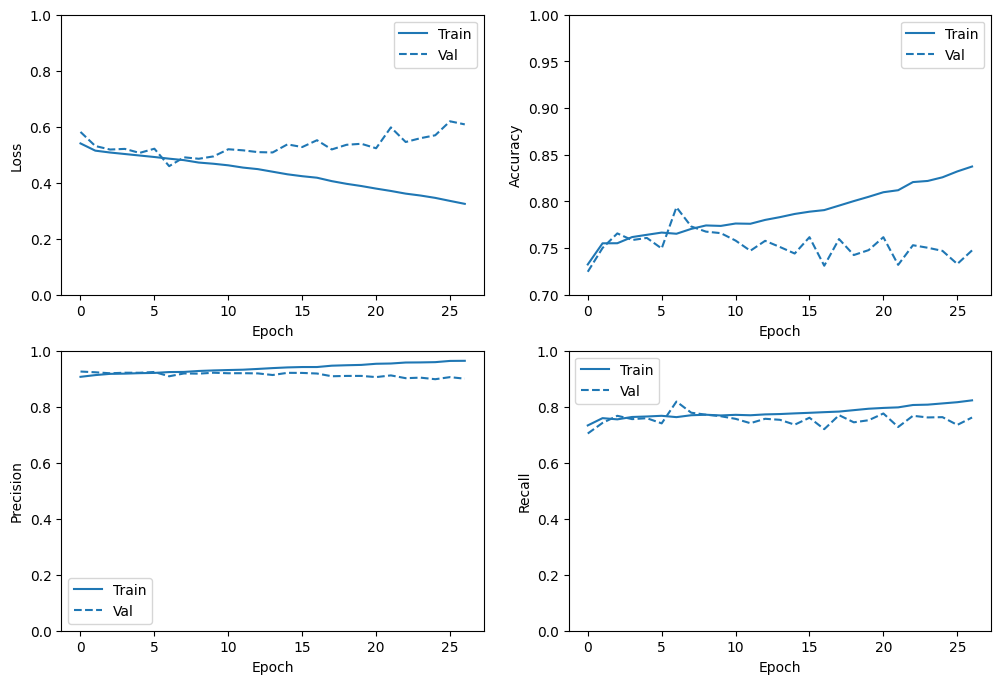

In [ ]:
plot_metrics(history)

In [ ]:
train_pred = rna.predict(X_train)
test_pred = rna.predict(X_test)

print('Número de exemplos positivos do conjunto de teste =', len(y_test[y_test > 0.9]))
results = rna.evaluate(X_test, y_test, verbose=0)

for name, value in zip(rna.metrics_names, results):
    print(f'{name}: {value:.4f}')

232/232 [==============================] - 0s 1ms/step
Número de exemplos positivos do conjunto de teste = 5800
loss: 0.4591
accuracy: 0.7937
precision: 0.9087
recall: 0.8184
auc: 0.8329


In [ ]:
precision = results[2]
recall = results[3]
F1 = 2*precision*recall/(precision + recall)
print(f'Pontuação F1 = {F1:.4f}')

Pontuação F1 = 0.8612


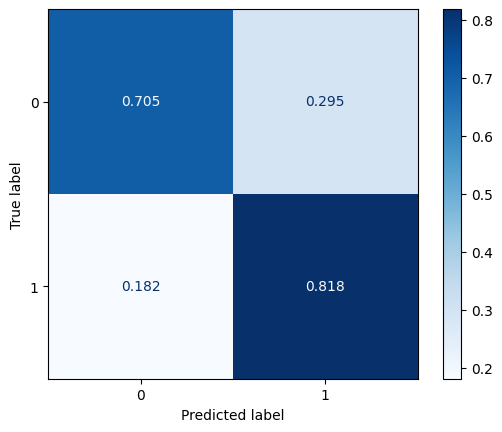

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred), 
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, np.round(test_pred))

0.7618199352116277

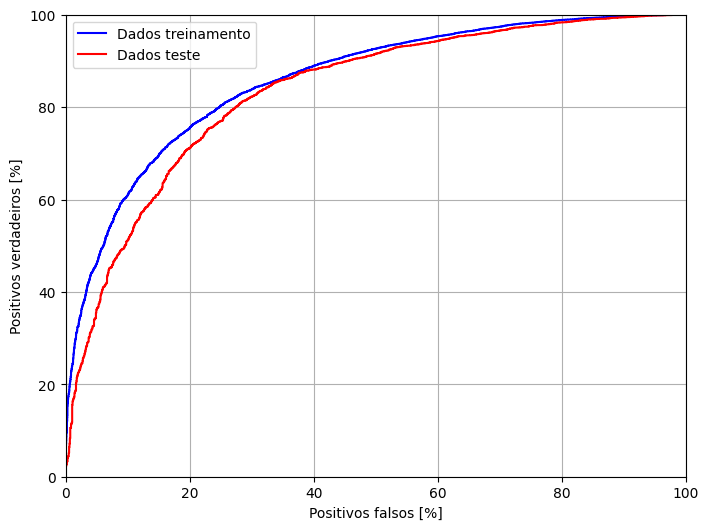

In [ ]:
fp_train, tp_train, _ = roc_curve(y_train, train_pred)
fp_test, tp_test, _ = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label='Dados treinamento')
plt.plot(100*fp_test, 100*tp_test, 'r', label='Dados teste')
plt.xlabel('Positivos falsos [%]')
plt.ylabel('Positivos verdadeiros [%]')
plt.xlim([0,100])
plt.ylim([0,100])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
custo_e_metricas_train = rna.evaluate(X_train, y_train)
custo_e_metricas_test = rna.evaluate(X_test, y_test)

232/232 [==============================] - 0s 2ms/step - loss: 0.4591 - accuracy: 0.7937 - precision: 0.9087 - recall: 0.8184 - auc: 0.8329
